In [1]:
# Package utilisé
# pytorch : https://pytorch.org/
# numpy : https://numpy.org/
# matplotlib : https://matplotlib.org/
# pandas : https://pandas.pydata.org/
# scikit-learn : https://scikit-learn.org/stable/

In [2]:
from importlib.metadata import version
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import math
from dataclasses import dataclass
from matplotlib import pyplot as plt
import time
import os

# Pour torch si vous avez un GPU
# device = "cpu" if not torch.cuda.is_available() else "cuda"
device = "cpu" # Pour forcer l'utilisation du CPU


In [3]:
# Environement potentielement testé
from environnement.environnement import Environnement as env # mother class
from environnement.environnement1 import Environnement1 as env1
from environnement.environnement2Str import Environnement2 as env2Str
from environnement.environnement3Str import Environnement3 as env3Str
from environnement.environnement6Str import Environnement6 as env6Str
from environnement.small_loop import small_loop

# model machine learning
from model.deepNN import *
from model.Tokenizer import *

# L'agent qui prédit l'avenir
Dans ce notebook nous allons implémenter un agent dévellopementale qui aura comme simple but de prédire le prochain feedback de son environement.

## Mécanisme de prédiction
Dans se notebook nous allons implémenté deux mécanismes de machine learning, un decision tree et un deep neural network. L'entrainement des deux modèls se fera sur la "vie" de l'agent. C'est à dire que les modèls s'entrainerons seulement sur les interactions que l'agents aura faites.

# Définition de l'agent

In [4]:
# Function pour la tokenization
def create_dico_numerate_word(all_words):
    """
    Fonction qui crée un dictionnaire avec les mots et leur index
    """
    dico = {}
    for i, word in enumerate(all_words):
        dico[word] = i
    return dico

In [5]:
class Agent1:
    def __init__(self, model, all_outcomes, all_actions, tokenizer, optimizer=None, loss_func=None):
        """ 
        Création de l'agent.
        
        - self._action : action précédente
        - self._predicted_outcome : prédiction de l'outcome précédent
        """
        self._action = None
        self._predicted_outcome = None
        self._model = model
        self._otimizer = optimizer
        self._loss_func = loss_func
        self._tokenizer:SimpleTokenizerV1 = tokenizer
        self._all_outcomes = all_outcomes
        self._all_actions = all_actions

    def fit(self, action, outcome):
        """
        Fonction d'entrainement de l'agent
        """
        action = self._tokenizer.encode(action)
        outcome = self._tokenizer.encode(outcome)

        try:
            self._model.train()
            action = torch.tensor([action], dtype=torch.float).to(device)
            outcome = torch.tensor(outcome, dtype=torch.long).to(device)
            outcome = torch.nn.functional.one_hot(outcome, num_classes=len(self._all_outcomes)).to(torch.float)
            train(model=self._model, 
                    train_data=[(action, outcome)],
                    optimizer=self._otimizer,
                    loss_func=self._loss_func,
                    nb_epochs=100,
                    print_=True)
        except Exception as e: # Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            self._model.fit(action, outcome)
            pass
       

    def predict(self, action):
        """
        Funciton de prédiction
        """
        action = self._tokenizer.encode(action)
        try:
            self._model.eval()
            action = torch.tensor([action], dtype=torch.float).to(device)
            print(f'Action: {action}')
            x = self._model(action)
            print(f'Prediction brut: {x}')
            x = torch.argmax(x, dim=0).item()
            print(f'Prediction: {x}')

        except: # Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            x=self._model.predict(action)
        
        return self._tokenizer.decode(x)

    def action(self, _outcome, fit=True):
        """ 
        Fonction qui choisit l'action a faire en fonction de la dernière \
        intéraction avec l'environnement. \n
        C'est ici que nous allons implémenter un mécanisme de ML \
        pour choisir la prochaine action.

        :param: **_outcome** feedback de la dernière intéraction avec l'environnement

        :return: **action** action à effectuer
        """
        if self._action is not None:
            print(f"Action: {self._action}, Prediction: {self._predicted_outcome}, Outcome: {_outcome}, " 
                  f"\033[0;31m Satisfaction: {self._predicted_outcome == _outcome} \033[0m")
            # Nous entrainons le model sur la dernière action et son outcome
            if fit:
                self.fit(self._action, _outcome)
            # Nous faisons une prédiction sur une action aléatoire
            self._action = np.random.choice(self._all_actions)
            print(f"Action aléatoire: {self._action}")
            self._predicted_outcome = self.predict(self._action)
            print(f"Prédiction: {self._predicted_outcome}")
        else:
            # Au début de la vie de l'agent, nous prennons la première action possible
            self._action = self._all_actions[0]
            print(f"Action de base : {self._action} aucune prédiciton pour la première action")
        
        return self._action, self._predicted_outcome

# Deep neural network
Nous allons utiliser un DNN, il a besoin d'une dimension d'entrée et de sortie. De plus plus nous pouvons ajouter des couches caché.
Les principe d'un Neural Network est de renvoyé un vecteur de taille _dimension sortie_, a partir d'un vecteur  Dans ce vecteur le Neural Network va prédire un certain chiffre, ce chiffre est ensuite normalisé pour donner une probablité.

## Exemple concret
Nous voulons donner au modèl une action et obtenir une prédiction d'un feedback. La sortie nous donnant un vecteur de probabilité, nous voulons un vecteur de même taille que tout les feedbacks possible. Nous prendrons la probabilité la plus haute comme prédiction.



In [6]:
env_test1:env = env1()

model_ML = DeepNetwork(hidden_size=[10, 5], input_size=1, output_size=2)
model_ML.to(device)
all_word = create_dico_numerate_word(env_test1.get_outcomes() + env_test1.get_actions())
tokenizer = SimpleTokenizerV1(all_word)
optimizer = torch.optim.Adam(model_ML.parameters(), lr=1e-1, weight_decay=1e-2)
loss_func = nn.CrossEntropyLoss()

agent = Agent1(
    model=model_ML,
    all_outcomes= env_test1.get_outcomes(),
    all_actions= env_test1.get_actions(),
    tokenizer=tokenizer,
    optimizer=optimizer,
    loss_func=loss_func)

outcome = None

history_good = []
pourcent_by_10 = []
for i in range(10):
    # Nous passons l'environnement à l'agent pour qu'il connaisse les actions et outcomes possibles
    print(f"=======================\033[0;32m iteration {i} \033[0m=======================")
    action, predi = agent.action(outcome)
    outcome = env_test1.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    print(f"Action choisie : {action} \033[0;34m{pourcent_by_10[-1]} \033[0m")
    time.sleep(1)
    print("\n\n")

liste hidden init [10, 5]
======================= iteration 0 =======================
Action de base : a aucune prédiciton pour la première action
Action choisie : a 0 



======================= iteration 1 =======================
Action: a, Prediction: None, Outcome: x,  Satisfaction: False 
Step 1/1, Accuracy: 0.5000 , Loss: 0.0029
Action aléatoire: b
Action: tensor([3.])
Prediction brut: tensor([ 3.6480, -3.7743], grad_fn=<ViewBackward0>)
Prediction: 0
Prédiction: x
Action choisie : b 0 


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass





======================= iteration 2 =======================
Action: b, Prediction: x, Outcome: y,  Satisfaction: False 
Step 1/1, Accuracy: 0.5000 , Loss: 0.0031
Action aléatoire: a
Action: tensor([2.])
Prediction brut: tensor([-2.7466,  2.6582], grad_fn=<ViewBackward0>)
Prediction: 1
Prédiction: y
Action choisie : a 0 



======================= iteration 3 =======================
Action: a, Prediction: y, Outcome: x,  Satisfaction: False 
Step 1/1, Accuracy: 0.5000 , Loss: 0.0103
Action aléatoire: a
Action: tensor([2.])
Prediction brut: tensor([ 2.2491, -2.3066], grad_fn=<ViewBackward0>)
Prediction: 0
Prédiction: x
Action choisie : a 0 



======================= iteration 4 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
Step 1/1, Accuracy: 0.5000 , Loss: 0.0185
Action aléatoire: b
Action: tensor([3.])
Prediction brut: tensor([ 1.9728, -2.0067], grad_fn=<ViewBackward0>)
Prediction: 0
Prédiction: x
Action choisie : b 0 



=======================

In [7]:
linear = torch.nn.Linear(1, 1)
print(linear.weight)
tmp = linear(torch.tensor([1.0]))

Parameter containing:
tensor([[-0.6983]], requires_grad=True)


En input nous aurons une variable, l'action réaliser. En outcome nous avons un vecteur de deux dimensions, la première dimension corespond au premier feedback possible de l'enviroment et le deuxième au deuxième.

# Exemple avec une chaine d'interaction
Contrairement à la méthode précédente, ici nous allons constitué une chaine d'interaction que l'agent fait en amont. On peut comparer cette constitution comme de l'exploration aléatoire de l'environement.

In [8]:
# On créer le jeu de donné d'exploration, on en profite pour générer un jeu de donnée de test
def make_data_set(tokenizer, _env:env, rand_iter:int = 100):
    # Create data val
    x_test = []
    y_test = []
    for i in range(1000):
        action = np.random.choice(_env.get_actions())
        feedback = _env.outcome(action)
        x_test.append(tokenizer.encode([str(action)]))
        y_test.append(str(feedback))
    y_test = tokenizer.encode(y_test)

    x_train = []
    y_train = []
    for i in range(rand_iter):

        action = np.random.choice(_env.get_actions())
        # print("debug 2002 rand act", action)
        feedback = _env.outcome(action)
        # print("debug 2002 fb de rand", feedback)
        # print("debug 2002 before encode action", action)
        x_train.append(tokenizer.encode([str(action)]))
        # print("debug 2002 after encode action", tokenizer.decode(x_train[-1]))
        y_train.append(str(feedback))

    # print("debuf 2002")
    # print(y_train)
    y_train = tokenizer.encode(y_train)
    # print("debug 2002 encode", y_train)
    # print("debug 2002 ", tokenizer.decode(y_train))
    # input("debug 2002")

    return x_train, y_train, x_test, y_test

def see_evolued_train_loss(train_loss):
    for i, loss_list in enumerate(train_loss):
        plt.plot(loss_list, label=f'Iteration {i}', color=plt.cm.viridis(i / len(train_loss)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.close()


liste hidden init [10, 5]
Epoch 1/100, Accuracy: 0.509
Epoch 2/100, Accuracy: 0.509
Epoch 3/100, Accuracy: 0.509
Epoch 4/100, Accuracy: 0.509
Epoch 5/100, Accuracy: 0.509
Epoch 6/100, Accuracy: 0.509
Epoch 7/100, Accuracy: 0.509
Epoch 8/100, Accuracy: 0.509
Epoch 9/100, Accuracy: 0.509
Epoch 10/100, Accuracy: 0.509
Epoch 11/100, Accuracy: 0.509
Epoch 12/100, Accuracy: 0.509
Epoch 13/100, Accuracy: 0.509
Epoch 14/100, Accuracy: 0.509
Epoch 15/100, Accuracy: 0.509
Epoch 16/100, Accuracy: 0.509
Epoch 17/100, Accuracy: 0.509
Epoch 18/100, Accuracy: 0.509
Epoch 19/100, Accuracy: 0.509
Epoch 20/100, Accuracy: 0.509
Epoch 21/100, Accuracy: 1.0
Epoch 22/100, Accuracy: 1.0
Epoch 23/100, Accuracy: 1.0
Epoch 24/100, Accuracy: 0.509
Epoch 25/100, Accuracy: 0.509
Epoch 26/100, Accuracy: 1.0
Epoch 27/100, Accuracy: 1.0
Epoch 28/100, Accuracy: 1.0
Epoch 29/100, Accuracy: 1.0
Epoch 30/100, Accuracy: 1.0
Epoch 31/100, Accuracy: 1.0
Epoch 32/100, Accuracy: 1.0
Epoch 33/100, Accuracy: 1.0
Epoch 34/100, A

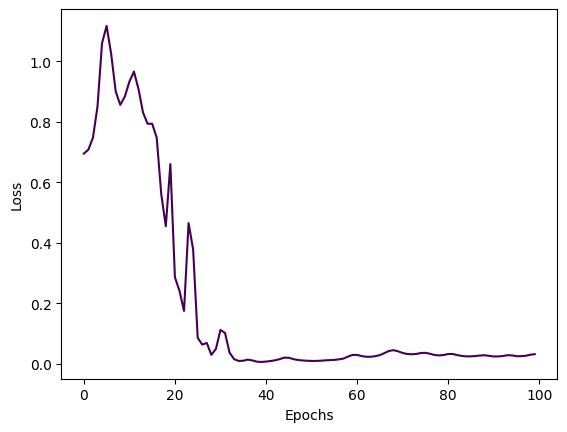

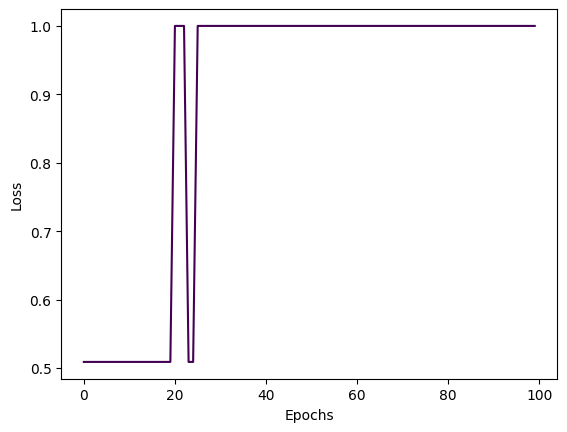

Action: a Prediction: tensor([ 1.3400, -1.4995], grad_fn=<ViewBackward0>), pour la séquence tensor([2.])
decode : 0 x
Action: b Prediction: tensor([-2.5475,  2.5132], grad_fn=<ViewBackward0>), pour la séquence tensor([3.])
decode : 1 y
Before passing to Agent1:
tensor([[-0.3162],
        [-0.1070],
        [ 0.5958],
        [ 0.3808],
        [ 0.4277],
        [ 0.4202],
        [-0.0081],
        [ 0.4314],
        [ 0.3391],
        [-0.1788]])
tensor([ 1.0412,  0.6085, -0.6825, -0.6874, -0.6859, -0.6248, -0.0050, -0.5497,
        -0.3859,  0.6037])
tensor([[-3.0143e-03, -3.4501e-03,  6.3313e-03,  4.9834e-03,  3.0948e-03,
         -2.6620e-04,  6.3679e-05,  6.5769e-03,  5.8431e-03, -3.7809e-03],
        [ 7.6790e-01,  5.0043e-01, -2.9879e-01, -4.1892e-01, -3.9129e-01,
         -3.2971e-01,  7.5389e-03, -2.6947e-01, -1.8353e-01,  4.8216e-01],
        [-6.8252e-01, -3.2163e-01,  8.1157e-01,  6.2732e-01,  6.5768e-01,
          6.1891e-01, -3.0091e-03,  6.0926e-01,  4.6796e-01, -4.5404

In [9]:
env_test2 = env1()
model_ML = DeepNetwork(hidden_size=[10, 5], input_size=1, output_size=2)
optimizer = torch.optim.Adam(model_ML.parameters(), lr=1e-1, weight_decay=1e-2)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(env_test2.get_outcomes() + env_test2.get_actions()))

x_train, y_train, x_test, y_test = make_data_set(tokenizer, env_test2, 10)

# debug 
# for x in x_train:
#     print(tokenizer.decode(x))
# print(tokenizer.decode(y_train))
# input('2012')

x_train = torch.tensor(x_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.int64).to(device)

# Transforme y_fit en one hot
y_train = torch.nn.functional.one_hot(y_train, len(env_test2.get_outcomes())).to(torch.float)

x_test = torch.tensor(x_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=32, shuffle=True
)

validate_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test),
    batch_size=32, shuffle=False
)

bast_acc, best_model, all_acc, all_loss = train_with_batch(model=model_ML,
                train_loader=data_loader,
                validate_loader=validate_loader,
                optimizer=optimizer,
                loss_func=loss_func,
                nb_epochs=100,
                print_=True
            )
see_evolued_train_loss([all_loss])
see_evolued_train_loss([all_acc])

# test model with each action
for act in env_test2.get_actions():
    action = tokenizer.encode([act])
    x = model_ML(torch.tensor(action, dtype=torch.float).to(device))
    print(f'Action: {act} Prediction: {x}, pour la séquence {torch.tensor(action, dtype=torch.float)}')
    print(f'decode : {torch.argmax(x, dim=0).item()} {tokenizer.decode(torch.argmax(x, dim=0).item())}')


print("Before passing to Agent1:")
for param in model_ML.parameters():
    print(param.data)


agent_test2 = Agent1(
    model=model_ML,
    all_outcomes= env_test2.get_outcomes(),
    all_actions= env_test2.get_actions(),
    tokenizer=tokenizer,
    optimizer=None,
    loss_func=None)

print("After passing to Agent1:")
for param in agent_test2._model.parameters():
    print(param.data)

history_good = []
pourcent_by_10 = []
for i in range(50):
    # Nous passons l'environnement à l'agent pour qu'il connaisse les actions et outcomes possibles
    print(f"=======================\033[0;32m iteration {i} \033[0m=======================")
    action, predi = agent_test2.action(outcome, False)
    outcome = env_test2.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    print(f'action {action} predi {predi} outcome {outcome}')
    print(f"Action choisie : {action} \033[0;34m{pourcent_by_10[-1]} \033[0m")
    time.sleep(1)
    print("\n\n")
    